##Install Library and preparing

In [1]:
!pip install torch
!pip install tf
!pip install -q gdown
!pip install transformers[torch] accelerate -U
!pip install accelerate -U
!pip install datasets
!pip install gensim
!pip install evaluate

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00


###Read Dataset and load Word2Vec

In [2]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

In [3]:
df_test1 = pd.read_csv("/content/pilpres_test_clean.csv")
# df_test2 = pd.read_csv("test_data_2.csv")
# df_test3 = pd.read_csv("test_data_3.csv")

In [4]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [5]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Downloading...
From (original): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3
From (redirected): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3&confirm=t&uuid=78376a1a-dd9f-4a66-be37-df6c0f9e7f4d
To: /content/model_w2v.zip
100%|██████████| 2.56G/2.56G [00:11<00:00, 214MB/s]


Extracting File...
Done.


In [6]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [7]:
x_train = df['Text']
y_train = df['Label']

In [8]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

In [9]:
# x_test2 = df_test2['Text']
# y_test2 = np.array(df_test2['Label'])

In [10]:
# x_test3 = df_test3['Text']
# y_test3 = np.array(df_test3['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [11]:
# Define the margin loss function
def margin_loss(y_true, y_pred):
    margin = K.constant(0.1)
    y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
    squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
    loss_pos = K.mean(y_true_float * squared_difference_pos)
    loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
    total_loss = loss_pos + lambda_val * loss_neg
    return total_loss

In [12]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000

In [13]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [14]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [15]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [16]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [17]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [18]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [19]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##CNN + LSTM

In [21]:
# Define the architecture of the hybrid model with he_normal initialization
static_input = Input(shape=(max_sequence_length,))
static_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(static_input)  # Removed weights parameter

# CNN Layers
static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_cnn_output = MaxPooling1D(2)(static_cnn_output)
static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
static_cnn_output = Dropout(0.5)(static_cnn_output)
batch_norm_layer_cnn = BatchNormalization()(static_cnn_output)

# LSTM Layer
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer_lstm = BatchNormalization()(static_lstm_output)

# Concatenate CNN and LSTM outputs
merged_layer = tf.keras.layers.concatenate([batch_norm_layer_cnn, batch_norm_layer_lstm], axis=-1)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(merged_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the hybrid model
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###CNN + LSTM BorderlineSMOTE Train and Test

In [22]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_borderline = hybrid_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=32,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5785 - loss: 0.1641 - val_accuracy: 0.5318 - val_loss: 0.1562
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8558 - loss: 0.0577 - val_accuracy: 0.9427 - val_loss: 0.0504
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9267 - loss: 0.0297 - val_accuracy: 0.9761 - val_loss: 0.0101
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9521 - loss: 0.0195 - val_accuracy: 0.9984 - val_loss: 0.0013
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9587 - loss: 0.0168 - val_accuracy: 0.9936 - val_loss: 0.0018
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9655 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 3.2141e-04
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9694 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 9.6480e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9662 - loss: 0.0142 - val_

In [23]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [24]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [25]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9794 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 1.6583e-05
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9788 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 8.0830e-05
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9753 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 2.1287e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9706 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 4.4271e-05
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0021
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2764e-06
Fold 1 - Training Loss: 0.0017970766639336944, Training Accuracy: 0.9966347813606262
Fold 1 - Validation Loss: 1.6583495380473323e-05, Validation Accuracy: 1.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

In [26]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9974143505096436, Std Training Accuracy: 0.0004896497798938604
Mean Training Loss: 0.0013062580721452833, Std Training Loss: 0.0002642293324622922
Mean Validation Accuracy: 0.9974499344825745, Std Validation Accuracy: 0.001625043294457468
Mean Validation Loss: 0.0011896316444108379, Std Validation Loss: 0.000791642435825045


In [27]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9948662855291392), 'f1-score': np.float64(0.9974238963827922), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.994960703134929), 'recall': np.float64(1.0), 'f1-score': np.float64(0.9974713443974494), 'support': np.float64(3137.0)}}


In [28]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_borderline.history['loss'][epoch]
    train_accuracy = history_hybrid_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_borderline.history['val_loss'][epoch]
    val_accuracy = history_hybrid_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [29]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9217 - loss: 0.0551
Hybrid Model Evaluation Results:
Accuracy: 0.9244791865348816


In [30]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       349
           1       0.69      0.31      0.43        35

    accuracy                           0.92       384
   macro avg       0.81      0.65      0.70       384
weighted avg       0.91      0.92      0.91       384



###CNN + LSTM KMeansSMOTE Train and Test

In [31]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [32]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_kmeans = hybrid_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=32,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9894 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9892 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9881 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9905 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9907 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9906 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9903 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9962 - lo

In [33]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [34]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [35]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9908 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9888 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9900 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 7.0059e-06
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9934 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 9.7819e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Fold 1 - Training Loss: 0.0008143241866491735, Training Accuracy: 0.9980517029762268
Fold 1 - Validation Loss: 0.0, Validation Accuracy: 1.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
      

In [36]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.998884254693985, Std Training Accuracy: 0.0004043188018983355
Mean Training Loss: 0.0005248668370768428, Std Training Loss: 0.00015574320062229578
Mean Validation Accuracy: 0.9988845884799957, Std Validation Accuracy: 0.001019966809939568
Mean Validation Loss: 0.0005770044982455147, Std Validation Loss: 0.0005232467968289662


In [37]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.997721727543766), 'f1-score': np.float64(0.9988584466961395), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9978191193163095), 'recall': np.float64(1.0), 'f1-score': np.float64(0.998907395448341), 'support': np.float64(3137.0)}}


In [38]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_kmeans.history['loss'][epoch]
    train_accuracy = history_hybrid_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_kmeans.history['val_loss'][epoch]
    val_accuracy = history_hybrid_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [39]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9090 - loss: 0.0592
Hybrid Model Evaluation Results:
Accuracy: 0.921875


In [40]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       349
           1       0.65      0.31      0.42        35

    accuracy                           0.92       384
   macro avg       0.79      0.65      0.69       384
weighted avg       0.91      0.92      0.91       384



###CNN + LSTM SVMSMOTE Train and Test

In [41]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [42]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_svm = hybrid_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=32,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9893 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9922 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9949 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9934 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9925 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9944 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9949 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9948 -

In [43]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [44]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [45]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9928 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9930 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9916 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9965 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 4.6748e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Fold 1 - Training Loss: 0.00035796407610177994, Training Accuracy: 0.9992915391921997
Fold 1 - Validation Loss: 0.0, Validation Accuracy: 1.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
     

In [46]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9995926558971405, Std Training Accuracy: 0.00019483512538177243
Mean Training Loss: 0.0001810980887967162, Std Training Loss: 9.335176414788454e-05
Mean Validation Accuracy: 0.9992033123970032, Std Validation Accuracy: 0.0010685686738607326
Mean Validation Loss: 0.00019652098999358713, Std Validation Loss: 0.0002674658470010809


In [47]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9984144042676549), 'f1-score': np.float64(0.9992054397312234), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9984053451127213), 'recall': np.float64(1.0), 'f1-score': np.float64(0.999200889294803), 'support': np.float64(3137.0)}}


In [48]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_svm.history['loss'][epoch]
    train_accuracy = history_hybrid_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_svm.history['val_loss'][epoch]
    val_accuracy = history_hybrid_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [49]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9248 - loss: 0.0517
Hybrid Model Evaluation Results:
Accuracy: 0.921875


In [50]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       349
           1       0.63      0.34      0.44        35

    accuracy                           0.92       384
   macro avg       0.78      0.66      0.70       384
weighted avg       0.91      0.92      0.91       384



##Evaluation

In [51]:
torch.cuda.empty_cache()

In [52]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###Hybrid

####BorderlineSMOTE

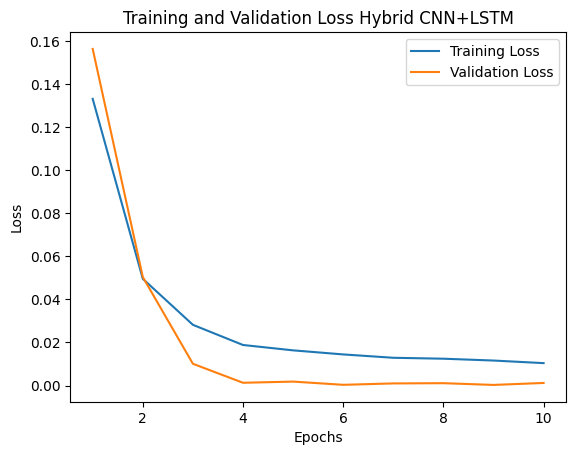

In [53]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_borderline.history['loss']
val_loss_hybrid = history_hybrid_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

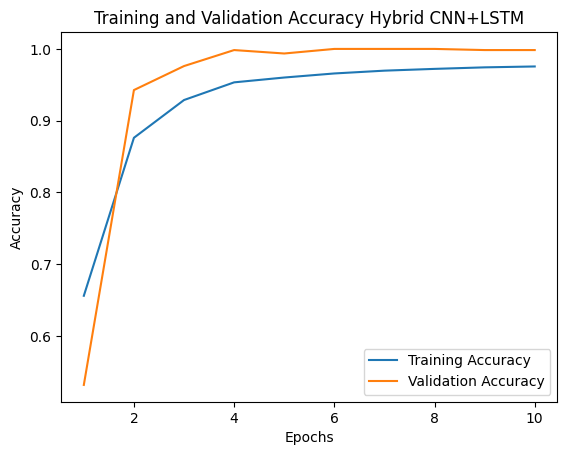

In [54]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_borderline.history['accuracy']
val_accuracy_hybrid = history_hybrid_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


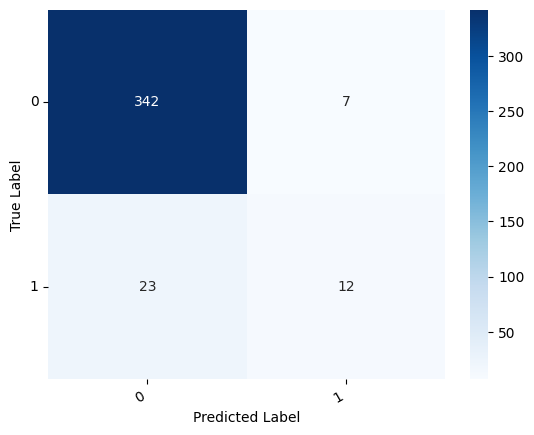

In [55]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####KMeansSMOTE

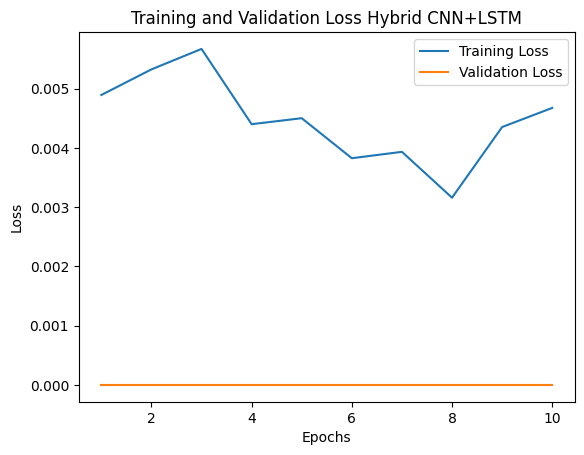

In [56]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_kmeans.history['loss']
val_loss_hybrid = history_hybrid_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

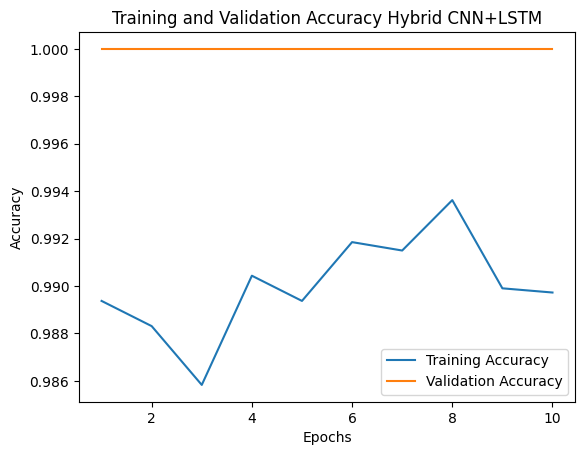

In [57]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_kmeans.history['accuracy']
val_accuracy_hybrid = history_hybrid_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


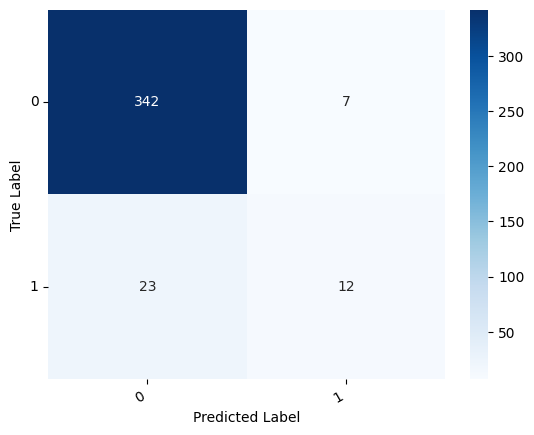

In [58]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####SVMSMOTE

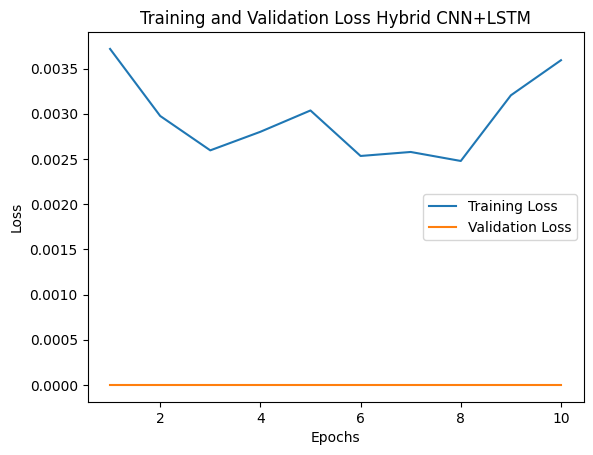

In [59]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_svm.history['loss']
val_loss_hybrid = history_hybrid_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

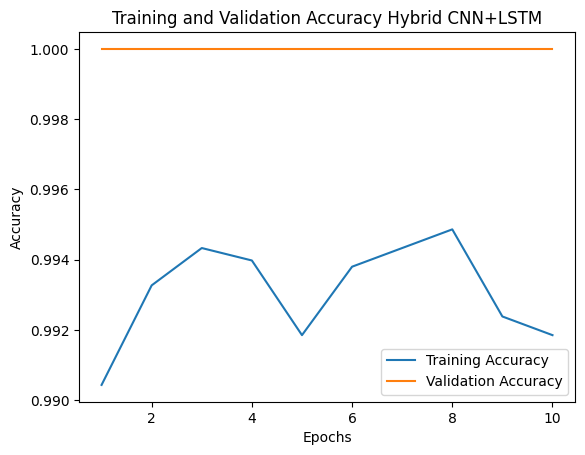

In [60]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_svm.history['accuracy']
val_accuracy_hybrid = history_hybrid_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


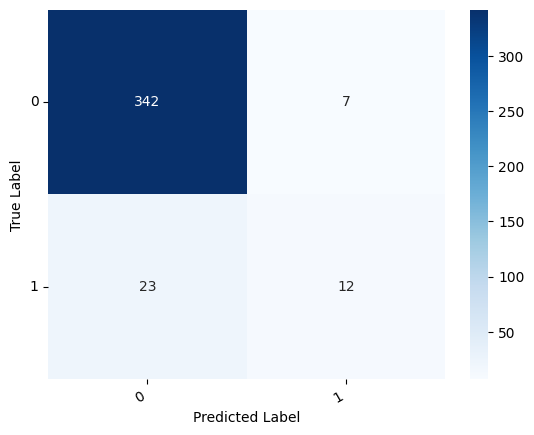

In [61]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

In [62]:
!zip -r CNNLSTMMarginLoss.zip ./* -x "sample_data/*"

  adding: idwiki_word2vec_768_new_lower.model (deflated 72%)
  adding: idwiki_word2vec_768_new_lower.model.syn1neg.npy (deflated 7%)
  adding: idwiki_word2vec_768_new_lower.model.wv.vectors.npy (deflated 7%)
  adding: metrics_hybrid_borderline.csv (deflated 50%)
  adding: metrics_hybrid_kmeans.csv (deflated 53%)
  adding: metrics_hybrid_svm.csv (deflated 55%)
  adding: model_w2v.zip (stored 0%)
  adding: pilpres_test_clean.csv (deflated 62%)
  adding: pilpres_train_balanced_clean.csv (deflated 75%)
